# Building A Suicide Text Classifier

## Importing Library

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [64]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [0]:
import re
import nltk

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

## Loading The Dataset

In [0]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/combined_sucide_detect.csv')

In [70]:
df.head()

,subreddit,selftext,title,name,is_sucide
0,SuicideWatch,We've been seeing a worrying increase in pro-s...,New wiki on how to avoid accidentally encourag...,t3_cz6nfd,1
1,SuicideWatch,"If you want to recognise an occasion, please d...",Reminder: Absolutely no activism of any kind i...,t3_d2370x,1
2,SuicideWatch,NaN,"sleep just isn't sleep anymore, it's an escape.",t3_gosr7c,1
3,SuicideWatch,"I just want to go to sleep, and never wake up",Fuck me,t3_gomrql,1
4,SuicideWatch,Seriously going through some existential stuff...,What is the point of living in this corrupt ce...,t3_gow0e9,1


## Suffling The dataset

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [72]:
df.shape

(1954, 5)

In [73]:
df.isnull().sum()

subreddit     0
selftext     83
title         0
name          0
is_sucide     0
dtype: int64

## Cleaning Data

In [0]:
df['selftext']=df['selftext'].fillna('No Text')

In [0]:
def clean_text(a):
  x=re.sub('[^a-zA-Z]', ' ', a)
  return x

In [0]:
df['selftext']=df['selftext'].apply(clean_text)

In [77]:
df.head()

,subreddit,selftext,title,name,is_sucide
0,SuicideWatch,i don t really know what the point of this pos...,planning,t3_gn7670,1
1,SuicideWatch,I am not attractive enough to get the kind of ...,I feel like I fucked up my life with bad food.,t3_goiuhd,1
2,depression,Hi I m not exactly sure if it s right place ...,Feeling like a depressed sociopath,t3_gonnaf,0
3,depression,So I just got on reddit today and looked at th...,I’m just so defeated...,t3_goo2su,0
4,SuicideWatch,so fucking tired of this shit nothing ever ge...,every hour of my life is another reason to kil...,t3_gnhz7u,1


In [0]:
text=df['selftext']

In [0]:
target=df['is_sucide']

In [0]:
x_train,x_test,y_train,y_test=train_test_split(text,target,random_state=42,test_size=0.2)

## Tokenizing and Paddding

In [0]:
tokenizer=Tokenizer()

In [0]:
tokenizer.fit_on_texts(text)

In [83]:
word_index=tokenizer.word_index
vocab_size=len(word_index)+1
vocab_size

10703

In [84]:
train_sequence=tokenizer.texts_to_sequences(x_train)
max_len=max(len(words) for words in train_sequence)
max_len

4917

In [0]:
train_sequence=tokenizer.texts_to_sequences(x_train)
max_len=max(len(words) for words in train_sequence)
train_padded=pad_sequences(train_sequence,maxlen=1000)

In [0]:
test_sequence=tokenizer.texts_to_sequences(x_test)
test_padded=pad_sequences(test_sequence,maxlen=1000)

In [87]:
# Used a api of globe for faster access
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size,100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-05-25 18:19:11--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c0a::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   179MB/s    in 1.8s    

2020-05-25 18:19:13 (179 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



## Building The Model

In [0]:
model=Sequential()

In [0]:
model.add(Embedding(vocab_size,100, input_length=1000, weights=[embeddings_matrix], trainable=False))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(326,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(625)))
model.add(Dense(1,activation='sigmoid'))

In [90]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         1070300   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1000, 652)         1113616   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1000, 652)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 1250)              6390000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1251      
Total params: 8,575,167
Trainable params: 7,504,867
Non-trainable params: 1,070,300
____________________________________

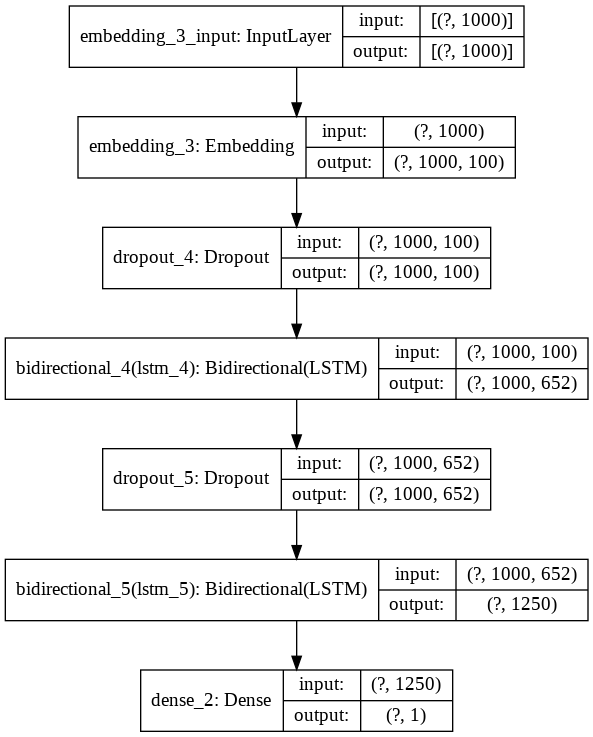

In [91]:
plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
filepath = os.path.join("./sucide_models/model_v{epoch}.hdf5")

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]

In [94]:
history=model.fit(train_padded,y_train,epochs=20,validation_data=(test_padded,y_test),callbacks=callbacks)

Epoch 1/20
49/49 [==============================] - ETA: 0s - loss: 0.7092 - accuracy: 0.5080
Epoch 00001: val_accuracy improved from -inf to 0.55754, saving model to ./sucide_models/model_v1.hdf5
49/49 [==============================] - 35s 709ms/step - loss: 0.7092 - accuracy: 0.5080 - val_loss: 0.6827 - val_accuracy: 0.5575
Epoch 2/20
49/49 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.5694
Epoch 00002: val_accuracy improved from 0.55754 to 0.57545, saving model to ./sucide_models/model_v2.hdf5
49/49 [==============================] - 34s 686ms/step - loss: 0.6821 - accuracy: 0.5694 - val_loss: 0.6741 - val_accuracy: 0.5754
Epoch 3/20
49/49 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.6052
Epoch 00003: val_accuracy did not improve from 0.57545
49/49 [==============================] - 33s 682ms/step - loss: 0.6592 - accuracy: 0.6052 - val_loss: 0.6731 - val_accuracy: 0.5499
Epoch 4/20
49/49 [==============================] - ETA: 0

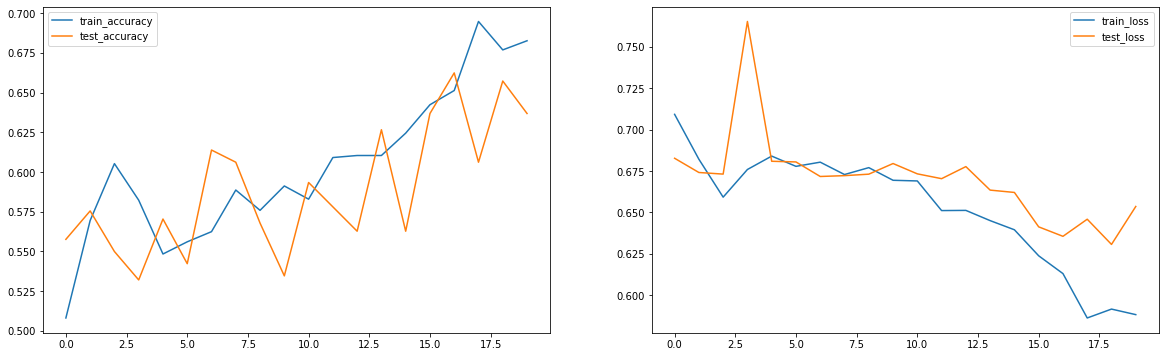

In [95]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(20,6))
ax1.plot(history.history['accuracy'],label='train_accuracy')
ax1.plot(history.history['val_accuracy'],label='test_accuracy')
ax1.legend()
ax2.plot(history.history['loss'],label='train_loss')
ax2.plot(history.history['val_loss'],label='test_loss')
ax2.legend()
plt.show()

## Loading Model and Checking Accuracy

In [0]:
classifier=load_model('/content/sucide_models/model_v17.hdf5')

In [0]:
prediction=classifier.predict(test_padded)

In [0]:
pr=(prediction>0.5)

In [113]:
print(confusion_matrix(y_test,pr))

[[121  77]
 [ 55 138]]


In [114]:
print(classification_report(y_test,pr))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65       198
           1       0.64      0.72      0.68       193

    accuracy                           0.66       391
   macro avg       0.66      0.66      0.66       391
weighted avg       0.66      0.66      0.66       391



## Predicting On New Messages

In [0]:
import pickle 
with open('tokenizer.pkl','wb') as f:
  pickle.dump(tokenizer,f)

In [0]:
#Depression Thought
text1='''I don't know, it's like this unexplainable feeling. 
Like this physical feeling in my heart that pulsates throughout my whole being. 
Whenever I hear happy music or watch a cheesy movie where everybody's happy I just can't help but feel sad. 
Same thing if I see something from when I was a kid or something similar. 
I'm thinking the root of it may be I've felt like I've missed out on life or didn't make the most of it? 
I don't know. I'm just hoping it's not just me.'''

In [0]:
tokens=tokenizer.texts_to_sequences([text1])
padded=pad_sequences(tokens,maxlen=1000)

In [0]:
predict=classifier.predict(padded)

In [125]:
pr=(predict>0.5)
if pr[0][0]==False:
  print("Depression")
else:
  print("Sucide")

Depression


In [0]:
#Sucide Thought
text2=''' It's been a year. An entire fucking year that I gave myself another chance. 
Or more like gave him another chance. Last year in October, I came close to killing myself. 
I had thought that nothing would ever get better and that there was absolutely no point living in a life that was FOR SURE never going to get better.
Yet, I gave God another chance. That morning, a pack of coyotes howled during the sunset as the last song in my playlist of songs I want played in my funeral had ended.
After hearing the coyotes, I thought it was a sign. A sign that God would make it better. 
'''

In [0]:
tokens=tokenizer.texts_to_sequences([text2])
padded=pad_sequences(tokens,maxlen=1000)

In [0]:
predict=classifier.predict(padded)

In [130]:
pr=(predict>0.5)
if pr[0][0]==False:
  print("Depression")
else:
  print("Sucide")

Sucide


## Conclusion:
* Model achived an highest accuracy of 66.24%
* It Predicted the output correctly, but model accuracy needs to be improved
* Accuracy can be improved by adding more text and cleaning the csv file properly